# Dask start

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45239")

# Import

In [3]:
import sys
sys.path.insert(1, '..')

In [4]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe
import xgcm
import os

In [5]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting params

In [6]:
#%matplotlib widget
%matplotlib inline

In [7]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [8]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

In [9]:
marker_list = ['o', '^', 's', 'D', 'X', '>']

In [10]:
 # Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14, title_fontsize=14)

# Useful functions

## Histograms

In [11]:
def compute_1D_histogram(dataSet, var1, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
    else :
        bins1 = bins
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), bins=[bins1], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [12]:
def compute_1D_histogram_vs_time(dataSet, var1, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
    else :
        bins1 = bins
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), bins=[bins1], dim=['x', 'y'], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [13]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None, normalize=False) :
    if normalize :
        variable1_to_use = (dataSet[var1]-dataSet[var1].mean())#/dataSet[var1].std()
        variable2_to_use = (dataSet[var2]-dataSet[var2].mean())#/dataSet[var2].std()
    else :
        variable1_to_use = dataSet[var1]
        variable2_to_use = dataSet[var2]   
    if bins is None :
        bins1 = np.linspace(variable1_to_use.min(), variable1_to_use.max(), nb_of_bins)
        bins2 = np.linspace(variable2_to_use.min(), variable2_to_use.max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(variable1_to_use.fillna(0), variable2_to_use.fillna(0), bins=[bins1, bins2], \
                     weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [14]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], \
                                   shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

## Distance between histograms

- Cross-entropy:
$$ H(P,Q) \equiv - \sum_i P(i) \log Q(i) $$
- Self-entropy:
$$H(P) \equiv - \sum_i P(i) \log P(i)$$

In [15]:
def H(hist_P, hist_Q, dims=None) :
    #masked_P = np.where(hist_P >0, hist_P, np.NaN)
    #masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    #return -np.nansum(hist_P*(np.log(masked_Q)))
    masked_Q = xr.where(hist_Q > 0, hist_Q, np.NaN)
    result = -(hist_P*(np.log(masked_Q)))
    return result.sum(dim=dims, skipna=True)

- Kullback-Leibler (KL) divergence (or relative entropy) 
$$ D_{KL} (P || Q) = H(P, Q) - H(P) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
a measure of how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.

In [16]:
def D_KL(hist_P, hist_Q, dims=None) :
    #masked_P = np.where(hist_P >0, hist_P, np.NaN)
    #masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    #return np.nansum(masked_P*(np.log(masked_P/masked_Q)))
    return H(hist_P, hist_Q, dims=dims)-H(hist_P, hist_P,  dims=dims)

- Symmertrized KL divergence (Jeffreys divergence):
$$ D_{sym} (P || Q) = D_{KL} (P || Q) + D_{KL} (Q || P) $$

In [17]:
def D_sym(hist_P, hist_Q) :
    return D_KL(hist_P, hist_Q)+D_KL(hist_Q, hist_P)

In [258]:
def H_diff(hist_P, hist_Q, dims=None) :
    #masked_P = np.where(hist_P >0, hist_P, np.NaN)
    #masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    #return np.nansum(masked_P*(np.log(masked_P/masked_Q)))
    return H(hist_P, hist_P, dims=dims)-H(hist_Q, hist_Q,  dims=dims)

In [19]:
def cross_H_diff(hist_P, hist_Q, dims=None) :
    #masked_P = np.where(hist_P >0, hist_P, np.NaN)
    #masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    #return np.nansum(masked_P*(np.log(masked_P/masked_Q)))
    return -H(hist_P, hist_Q, dims=dims)+H(hist_Q, hist_P,  dims=dims)

In [20]:
def L1(hist_P, hist_Q, dims=None) :
    result = hist_P*(hist_P - hist_Q)
    return result.sum(dim=dims, skipna=True)

# Load data

Choose cases

In [21]:
data=[dict() for i in range(6)]

In [22]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'Gulf Stream/Winter'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'Gulf Stream/Summer'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'Mid Atlantic/Winter'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'Mid Atlantic/Winter'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'West Medit/Winter'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'West Medit/Summer'})

## eNATL60

In [23]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [24]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,10),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [233]:
%%time
for i in range(len(data)) :
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).\
    to_dask().drop(['qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux'],errors='ignore')
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk({'x' : -1, 'y' : -1, 'time_counter' : 15})
    data[i]['HR'] = current_set
    data[i]['HR'] = data[i]['HR'].rename({'time_counter': 't'})
    data[i]['HR'].attrs['source'] = 'eNATL60'

CPU times: user 738 ms, sys: 25.7 ms, total: 764 ms
Wall time: 2.8 s


In [234]:
data[i]['HR']

<xarray.Dataset>
Dimensions:        (y: 674, x: 573, t: 221)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(674, 573), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(674, 573), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(674, 573), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(674, 573), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(674, 573), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(674, 573), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(674, 573), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(674, 573), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(674, 573), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(674, 573), meta=np.ndarray>
    time_centered  (t) datetime64[ns] dask.array<chunksize=(15,), meta=np.ndarray>
  * t              (t) datetime64[ns] 2009-08-01T00:30:00 ... 2009-10-31T16:3...
Dimensions without coordinates: y, x
Data variables:
    fmask          (y, x) int8 dask.array<chunksize=(674, 573), meta=np.ndarray>
    sosaline       (t, y, x) float32 dask.array<chunksize=(15, 674, 573), meta=np.ndarray>
    sosstsst       (t, y, x) float32 dask.array<chunksize=(15, 674, 573), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(674, 573), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(674, 573), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(674, 573), meta=np.ndarray>
Attributes:
    source:   eNATL60

## eORCA025

In [191]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("../Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : 150, 'x' : -1, 'y' : -1}).\
                                          rename(nav_lat='lat', nav_lon='lon')
    data[i]['LR'].attrs['source'] = 'eORCA025'
    data[i]['LR'] = data[i]['LR'].rename({'time_counter': 't'})

# Grid metrics for xgcm

## HR grid

In [172]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('X', 'Y',): ['area'] # Areas 
}

In [173]:
chunk_dict = {'x_c' : -1, 'y_c' : -1, 'x_r' : -1, 'y_r' : -1, 't' : 150}

Rename and arrange the coordinates to make data suitable for xgcm and xESMF regridding :

In [174]:
def make_HR_grid(current_set) :
    ds = xr.Dataset({},
                   coords={"x_c": np.arange(len(current_set['x'])),\
                           "y_c": np.arange(len(current_set['y'])) ,\
                           "x_r": np.arange(0.5,0.5+len(current_set['x']),1.),\
                           "y_r": np.arange(0.5,0.5+len(current_set['y']),1.),\
                           "t" : current_set['time_counter'].values})
    
    ds.coords['e1t'] = xr.DataArray(current_set.coords['e1t'].values, dims=['y_c', 'x_c'])
    ds.coords['e2t'] = xr.DataArray(current_set.coords['e2t'].values, dims=['y_c', 'x_c'])
    ds.coords['tmask'] = xr.DataArray(current_set['tmask'].values, dims=['y_c', 'x_c'])

    ds.coords['e1u'] = xr.DataArray(current_set.coords['e1u'].values, dims=['y_c', 'x_r'])
    ds.coords['e2u'] = xr.DataArray(current_set.coords['e2u'].values, dims=['y_c', 'x_r'])
    ds.coords['umask'] = xr.DataArray(current_set['umask'].values, dims=['y_c', 'x_r'])

    ds.coords['e1v'] = xr.DataArray(current_set.coords['e1v'].values, dims=['y_r', 'x_c'])
    ds.coords['e2v'] = xr.DataArray(current_set.coords['e2v'].values, dims=['y_r', 'x_c'])
    ds.coords['vmask'] = xr.DataArray(current_set['vmask'].values, dims=['y_r', 'x_c'])

    ds.coords['e1f'] = xr.DataArray(current_set.coords['e1f'].values, dims=['y_r', 'x_r'])
    ds.coords['e2f'] = xr.DataArray(current_set.coords['e2f'].values, dims=['y_r', 'x_r'])
    ds.coords['fmask'] = xr.DataArray(current_set['fmask'].values, dims=['y_r', 'x_r'])

    ds.coords['depth'] = xr.DataArray(current_set['depth'].values, dims=['y_c', 'x_c'])
    ds.coords['lat'] = xr.DataArray(current_set['lat'].values, dims=['y_c', 'x_c'])
    ds.coords['lon'] = xr.DataArray(current_set['lon'].values, dims=['y_c', 'x_c'])
    
    ds = ds.chunk(chunk_dict)
    
    ds['sosstsst'] = current_set['sosstsst'].\
    reset_coords(names=['e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], \
                 drop=True).\
    reindex(y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
    rename(y='y_c', x='x_c', time_counter='t')
    ds['sosaline'] = current_set['sosaline'].\
    reset_coords(names=['e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], \
                 drop=True).\
    reindex(y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
    rename(y='y_c', x='x_c', time_counter='t')
    ds.coords['area'] = ds['e1t']*ds['e2t']
    
    # Preparation of corner coordinates for the regridder
    ds = xgcm.autogenerate.generate_grid_ds(ds, axes_dims_dict={'X' : 'x_c', 'Y' : 'y_c'}, \
                                                axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    ds = ds.rename({'x_c_outer': 'x_b','y_c_outer': 'y_b'})
    
    HR_grid = xgcm.Grid(ds, metrics=metrics, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r', 'outer' : 'x_b'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r', 'outer' : 'y_b'}})
    ds.coords['lon_b'] = HR_grid.interp(da=ds['lon_outer'].load(), axis='Y', to='outer',boundary='extend')
    ds.coords['lat_b'] = HR_grid.interp(da=ds['lat_outer'].load(), axis='X', to='outer',boundary='extend')
    
    ds = ds.chunk(chunk_dict | {'x_b' : -1, 'y_b' : -1})
    
    return ds

## LR grid

In [175]:
global_grid_LR = xr.open_dataset('../global_eORCA025_mesh.nc', chunks='auto')
global_grid_LR.coords['area'] = global_grid_LR['e1t']*global_grid_LR['e2t']

In [176]:
global_grid_LR

<xarray.Dataset>
Dimensions:  (y: 1205, y_r: 1205, x: 1440, x_r: 1440, x_b: 1441, y_b: 1206)
Coordinates: (12/29)
  * y        (y) int64 1 2 3 4 5 6 7 8 ... 1199 1200 1201 1202 1203 1204 1205
  * y_r      (y_r) float64 1.5 2.5 3.5 4.5 ... 1.204e+03 1.204e+03 1.206e+03
  * x        (x) int64 1 2 3 4 5 6 7 8 ... 1434 1435 1436 1437 1438 1439 1440
  * x_r      (x_r) float64 1.5 2.5 3.5 4.5 ... 1.438e+03 1.44e+03 1.44e+03
    lat      (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    llat_cr  (y, x_r) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    ...       ...
    fmask    (y_r, x_r) int8 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * x_b      (x_b) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y_b      (y_b) float64 0.5 1.5 2.5 3.5 ... 1.204e+03 1.204e+03 1.206e+03
    lon_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    lat_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    area     (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Data variables:
    *empty*

# Filters

## Routines

In [177]:
def gaussian_filter(data, filter_coef):
    #data = data.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    # Filtering with a fixed factor
    #dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
    #dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
    #dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
    #dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
    #dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
    #dx_max = max(dxw.max(),dys.max()).values
    #filter_scale = filter_coef*dx_max

    #kappa_w = dxw * dxw / (dx_max * dx_max)
    #kappa_s = dys * dys / (dx_max * dx_max)
    # # define the filter (filtering with a fixed factor)
    # gaussian_filter = gcm_filters.Filter(
    #     #n_iterations=2,
    #     filter_scale=filter_scale,    
    #     dx_min=dx_min,
    #     filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    #     grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    #     grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
    #         'kappa_w': kappa_w, 'kappa_s': kappa_s} )
    dx_min = 1
    filter_simple_fixed_factor = gcm_filters.Filter(
        filter_scale=filter_coef,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )
    # apply filter to HR data
    data_filtered = xr.Dataset({}, coords=data.coords)
    data_filtered = filter_simple_fixed_factor.apply(data, dims=['y', 'x'])
    data_filtered = data_filtered.isel(dict(y=slice(filter_coef//2,-filter_coef//2),x=slice(filter_coef//2,-filter_coef//2)))
    return data_filtered

In [178]:
def regrid(data_entity, data_key) :
    #ds = vars_before_coars(data_entity['HR_new_coords'], data_entity['HR_grid'])
    ds = data_entity[data_key].drop_dims(['x_r', 'y_r']).drop_vars(['lon_outer', 'lat_outer', 'e1t', 'e2t'], errors='ignore').\
    rename({'x_c' : 'x', 'y_c' : 'y', 'tmask' : 'mask'})
    
    #ds['area']=ds['e1t']*ds['e2t']
    
    # to take a part of the global grid corresponding to the data cut
    selection = global_grid_LR.lon.where((global_grid_LR.lon>=ds.lon.min().values) & (global_grid_LR.lon<=ds.lon.max().values) &\
                                  (global_grid_LR.lat>=ds.lat.min().values) & (global_grid_LR.lat<=ds.lat.max().values), drop=True)
    selected_x = list(selection.x.values)
    selected_y = list(selection.y.values)
    sel_grid_LR = global_grid_LR.isel(x=selected_x[0:-1], x_b=selected_x, y=selected_y[0:-1], y_b=selected_y, \
                                      x_r=selected_x[0:-1], y_r=selected_y[0:-1])
    
    # reinit x and y arrays
    sel_grid_LR.coords['x'] = np.arange(1,len(selected_x)); sel_grid_LR.coords['y'] = np.arange(1,len(selected_y))
    sel_grid_LR.coords['x_b'] = np.arange(1,len(selected_x)+1)-0.5; sel_grid_LR.coords['y_b'] = np.arange(1,len(selected_y)+1)-0.5
    sel_grid_LR.coords['x_r'] = np.arange(1,len(selected_x))+0.5; sel_grid_LR.coords['y_r'] = np.arange(1,len(selected_y))+0.5
    
    # create regridder, i.e. compute weights
    # TODO : save weights and reuse them (can accelerate pre-treatment)
    regridder = xe.Regridder(ds, sel_grid_LR, method="conservative_normed")
    
    # perform coarsening
    data_entity['HR_coarsened'] = regridder(ds)
    data_entity['HR_coarsened'] = data_entity['HR_coarsened'].drop_dims(['x_b', 'y_b'])
    data_entity['HR_coarsened'] = xr.merge([sel_grid_LR.drop_dims(['x_b', 'y_b']), \
                                  data_entity['HR_coarsened']], compat='override')
    data_entity['HR_coarsened'] = (data_entity['HR_coarsened'].rename({'x': 'x_c', 'y' : 'y_c'})).persist()
    
    #create grid for xgcm
    metrics_LR = {
        ('X',): ['e1t', 'e1u', 'e1v'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
        ('X', 'Y',): ['area'] }
    data_entity['HR_coarsened_grid'] = xgcm.Grid(data_entity['HR_coarsened'], metrics=metrics_LR, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r'}})
    return data_entity

In [179]:
def apply_filter_and_downsample(data_entity, filter_coef, coarse_flag=True) :
    if (filter_coef > 0) :
        data_entity['HR_filtered'] = gaussian_filter(data_entity['HR'], filter_coef)
        data_entity['HR_filtered'] = make_HR_grid(data_entity['HR_filtered'])
        # spatial coarsening
        if (coarse_flag) :
            data_entity = regrid(data_entity, 'HR_filtered')
    else :
        if (coarse_flag) :
            data_entity['HR_new_coords'] = make_HR_grid(data_entity['HR'])
            data_entity = regrid(data_entity, 'HR_new_coords')

    return data_entity

## Set of filters to compare

In [36]:
filters = [dict({'filter_coef' : 0, 'coarsening' : True, 'label' : 'Coarse to 0.25°'}),
          dict({'filter_coef' : 15, 'coarsening' : True, 'label' : 'Filter 0.25° + Coarse to 0.25°'}),
          dict({'filter_coef' : 30, 'coarsening' : True, 'label' : 'Filter 0.5° + Coarse to 0.25°'}),
          dict({'filter_coef' : 45, 'coarsening' : True, 'label' : 'Filter 1° + Coarse to 0.25°'}),
          dict({'filter_coef' : 90, 'coarsening' : True, 'label' : 'Filter 2° + Coarse to 0.25°'})]

## Perform filter of all datasets

In [37]:
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET'] 

In [38]:
# ## approx 1 hour
# %%time
# for i, data_entity in enumerate(data) : 
#     for ifilter, curr_filter in enumerate(filters) :
#         data_entity = apply_filter_and_downsample(data_entity, curr_filter['filter_coef'], coarse_flag=curr_filter['coarsening'])
#         data_entity['HR_coarsened'].to_zarr(store=f'{SCRATCH_BUCKET}/data'+str(i)+'filter'+str(ifilter)+'.zarr', mode='w')  # write data
#         print('Finished dataset '+str(i)+' '+curr_filter['label'])

In [66]:
%%time
for i, data_entity in enumerate(data) : 
    data_entity['HR_Filtered'] = [xr.Dataset() for j in range(len(filters))]
    for ifilter, curr_filter in enumerate(filters) :
        data_entity['HR_Filtered'][ifilter] = xr.open_zarr(f'{SCRATCH_BUCKET}/data'+str(i)+'filter'+str(ifilter)+'.zarr', chunks='auto')
        if not('x' in data_entity['HR_Filtered'][ifilter].coords) :
            data_entity['HR_Filtered'][ifilter] = data_entity['HR_Filtered'][ifilter].rename({'x_c' : 'x', 'y_c' : 'y'})

CPU times: user 1.53 s, sys: 67.8 ms, total: 1.6 s
Wall time: 13 s


# Method

## Quantities used to compare eORCA025 with filtered eNATL60

The squares of finite differences $|\delta \textbf{x} \cdot \nabla \overline{T}|^2$ and $|\delta \textbf{x} \cdot \nabla \overline{S}|^2$ are good candidates for statistical testing of the spatial filtering procedures because:
- They are used as predictors for subgrid variance in previous studies.
If we are capable to 
- They are sensitive to "smoothness" of the fields and to the choice of the filter
- Easy to extract

## Use entropy difference as metrics for detection of under- or over-fitltering situations

- Difference of self-entropies of two distributions is defined as:
$$ \Delta H (P, Q) = H(P) - H(Q) = - \sum_i P(i) \log P(i) + \sum_i Q(i) \log Q(i) $$
This difference $\Delta H$ can be negative when there is a significant contribution from bins $i$ where $Q(i)>P(i)$. We can use the sign and proximity to 0 of $\Delta H$ as an indicator of over- or under-fitting cases, in particular:
- if $ \Delta H \approx 0 $ the two distributions contain more or less the same information, the difference is small. This would be the case of "ideal" filter, when filtered data reproduces correctly the considered stats of the reference data.
- if $ \Delta H > 0 $ the information content of the referential distribution $P$ is <b>larger</b>. If we put eORCA025 distributions as the reference $P$ this case would correspond to the situation when ORCA025 data contains a larger variety of gradients comparing to the filtered eNATL60 data, so the entropy of $P$ is higher. This case would correspond to <i> over-filtering </i>, as some features presented in LR data are lost due to filtering, and it should be <b>avoided</b>.
- if $ \Delta H < 0 $ the reference distribution $P$ contains less information than the approximating distribution $Q$. In other words, the filtered fields still contain some features from HR data, not represented in LR-simulation data. This case would correspond to <i> under-filtering</i>. But this situation should be acceptable, because the most important is that the filtered data contains the small-scale features that can appear in ORCA025. If it contains some more events, like some stronger gradients absent in ORCA025, it should not be an issue, since the parametrization will adapt to weaker gradients.

The main idea is to find such a filter that would <b>not allow over-filtering</b> in none of the data sets (in all regions and seasons). At the same time, the situation with under-filtering should be considered as acceptable. Therefore, we will look for a filter that gives $ \Delta H \approx 0 $ or $ \Delta H > 0 $ in all datasets, but not negative.

# Statistics of the finite differences

Finite-difference evaluation of squares of the local gradients:
$$ \Delta_x T(x,y)\equiv \frac{1}{2} \left[\overline{T}(x+\Delta x, y) - \overline{T}(x - \Delta x, y)\right] $$
$$ \Delta_y T(x,y)\equiv \frac{1}{2} \left[\overline{T}(x, y+\Delta y) - \overline{T}(x, y- \Delta y)\right] $$
$$ |\delta x \cdot \nabla \overline{T}|^2 (x,y) \equiv [\Delta_x T(x,y)]^2 + [\Delta_y T(x,y)]^2 $$
and the same for salinity.

In [241]:
# def diffs_x(dataArray) :
#     return (dataArray.shift(x=-1) - dataArray)
# def diffs_y(dataArray) :
#     return (dataArray.shift(y=-1) - dataArray)
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [242]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["diff_x_T"] = central_diffs_x(ds['sosstsst'])
        ds["diff_y_T"] = central_diffs_y(ds['sosstsst'])
        ds["diff_x_S"] = central_diffs_x(ds['sosaline'])
        ds["diff_y_S"] = central_diffs_y(ds['sosaline'])
        ds["diff_T_sqr"] = ds["diff_x_T"]**2 + ds["diff_y_T"]**2
        ds["diff_S_sqr"] = ds["diff_x_S"]**2 + ds["diff_y_S"]**2
        ds = ds.isel(dict(y=slice(2,-2),x=slice(2,-2)), drop=True).copy(deep=True)

CPU times: user 3.15 s, sys: 16.4 ms, total: 3.17 s
Wall time: 3.14 s


In [243]:
bord_cut = dict(y=slice(2,-2),x=slice(2,-2))

In [244]:
nb_of_bins = 150

In [245]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'eNATL60'})
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

## 1D histograms

In [246]:
%%time
normalized = False
for variable in ["diff_T_sqr", "diff_S_sqr"] :
    for i in range(len(data)) :
        #ref_hist = compute_1D_histogram(data[i]['HR_Filtered'][2][bord_cut], variable, nb_of_bins, bins=None).compute()
        ref_hist = compute_1D_histogram(data[i]['LR'], variable, nb_of_bins, bins=None).compute()
        ref_bins = ref_hist[variable+'_bin'].data
        
        hists[i]['LR'][variable] = compute_1D_histogram(data[i]['LR'][bord_cut], variable, nb_of_bins, bins=ref_bins).compute()
        #print(hists[i]['LR'][variable].sum().values)

        for ifilter in range(len(filters)) :
            hists[i]['HR_Filtered'][ifilter][variable] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], \
                                                                              variable, nb_of_bins, bins=ref_bins)
            #print(hists[i]['HR_Filtered'][ifilter][variable].sum())

CPU times: user 4.13 s, sys: 64.1 ms, total: 4.19 s
Wall time: 8.6 s


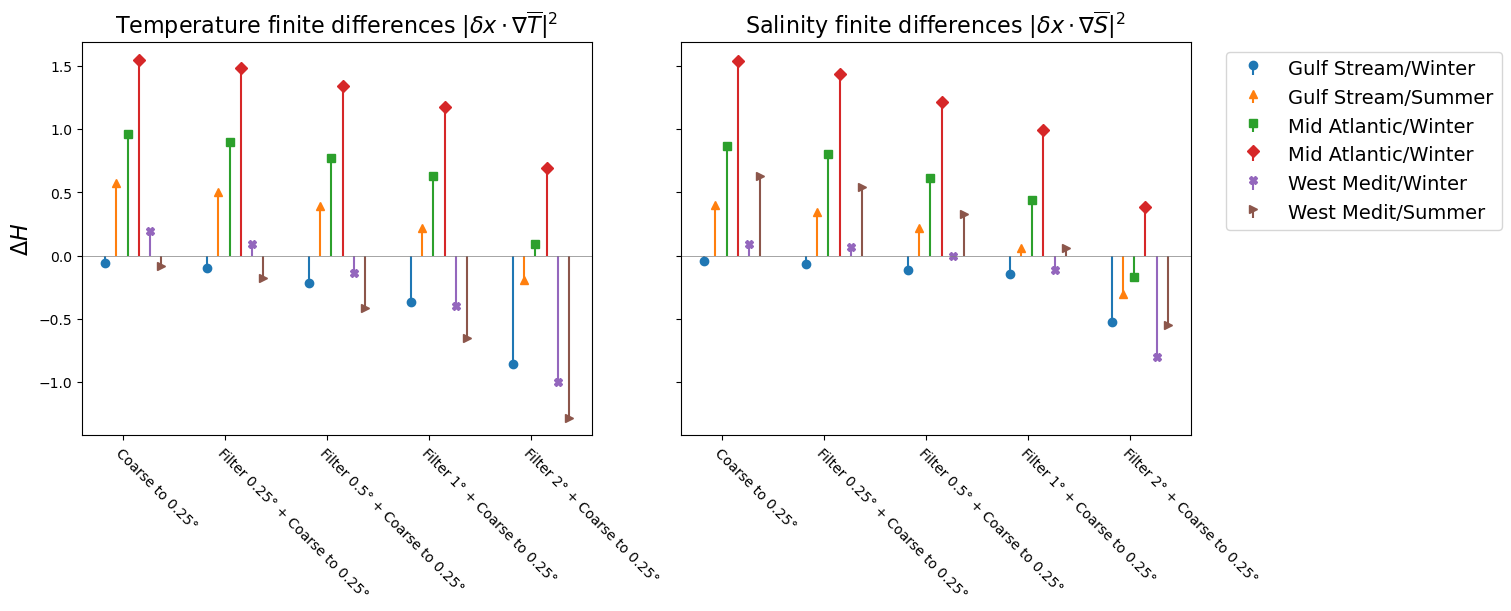

CPU times: user 7.5 s, sys: 417 ms, total: 7.92 s
Wall time: 53 s


In [260]:
%%time
fig, axis = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 6), sharey=True)
#fig.suptitle('Distance between 1D histograms $D_{KL}$ (eORCA025, Filtered eNATL60)')
x = np.arange(len(filters))
bar_width = 0.11
for i_dataset in range(len(data)) :
    marker_style = 'C'+str(i_dataset)+marker_list[i_dataset]
    line_style = 'C'+str(i_dataset)+'-'
    markerline, stemlines, baseline = axis[0].stem(x+(i_dataset)*bar_width, [H_diff(hists[i_dataset]['HR_Filtered'][ifilter]['diff_T_sqr'],\
                                                                                   hists[i_dataset]['LR']['diff_T_sqr']) \
                                          for ifilter in range(len(filters))], markerfmt=marker_style, basefmt=" ", linefmt=line_style)
    markerline, stemlines, baseline = axis[1].stem(x+(i_dataset)*bar_width, [H_diff(hists[i_dataset]['HR_Filtered'][ifilter]['diff_S_sqr'],\
                                                                                    hists[i_dataset]['LR']['diff_S_sqr']) \
                                          for ifilter in range(len(filters))], markerfmt=marker_style, basefmt=" ", \
                                                   linefmt=line_style, label=data[i_dataset]['label'])
for ax in axis :
    ax.set_xticks(x + 1.6*bar_width)
    ax.set_xticklabels([filt['label'] for filt in filters],fontsize=10,rotation = -45,ha="left", rotation_mode="anchor")
    ax.set(yscale='linear')
    ax.axhline(y=0., color='grey', ls='-', lw=0.5)
    #ax.set(ylim=[-0.2,0.2])
axis[0].set(title=r'Temperature finite differences $|\delta x \cdot \nabla \overline{T}|^2$', ylabel=r'$\Delta H$')
axis[1].set(title=r'Salinity finite differences $|\delta x \cdot \nabla \overline{S}|^2$')
axis[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Case of similar distributions 

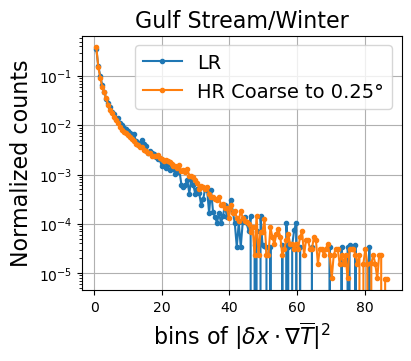

In [249]:
ifilter = 0 # pure coarse
region = 0
quantity='diff_T_sqr'

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.5), sharey=True)
hists[region]['LR'][quantity].plot(ax=ax, ls='-', marker='.', label='LR')
hists[region]['HR_Filtered'][ifilter][quantity].plot(ax=ax, ls='-', marker='.', label='HR '+filters[ifilter]['label'])

ax.set(title=data[region]['label'], xlabel=r'bins of $|\delta x \cdot \nabla \overline{T}|^2$', ylabel='Normalized counts')
ax.set(yscale='log')
ax.grid(True)
ax.legend()
plt.show()

[Text(0.5, 1.0, '')]

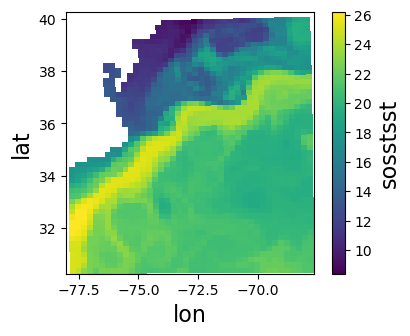

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.25))
data[0]['HR_Filtered'][0].isel(t=-1)['sosstsst'].plot(x='lon', y='lat', ax=ax)
ax.set(title=None)

[Text(0.5, 1.0, ''), Text(0.5, 0, 'lon'), Text(0, 0.5, 'lat')]

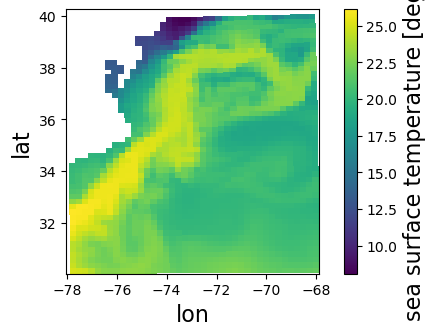

In [251]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4.25, 3.25))
plot = data[0]['LR'].isel(t=-1)['sosstsst'].plot(x='lon', y='lat', ax=ax)
plot.colorbar = None
ax.set(title=None, xlabel='lon', ylabel='lat')

## Case of overfiltering 

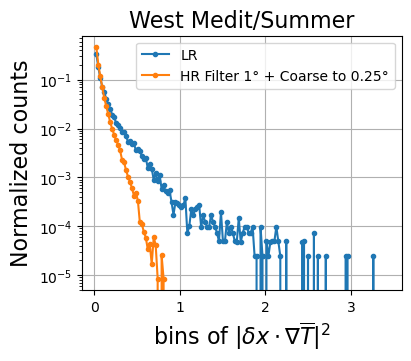

In [252]:
ifilter = 3
region = 5
quantity='diff_T_sqr'

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.5), sharey=True)
hists[region]['LR'][quantity].plot(ax=ax, ls='-', marker='.', label='LR')
hists[region]['HR_Filtered'][ifilter][quantity].plot(ax=ax, ls='-', marker='.', label='HR '+filters[ifilter]['label'])

ax.set(title=data[region]['label'], xlabel=r'bins of $|\delta x \cdot \nabla \overline{T}|^2$', ylabel='Normalized counts')
ax.set(yscale='log', xscale='linear')
ax.grid(True)
ax.legend(fontsize=10)
plt.show()

[Text(0.5, 1.0, ''), Text(0.5, 0, 'lon'), Text(0, 0.5, 'lat')]

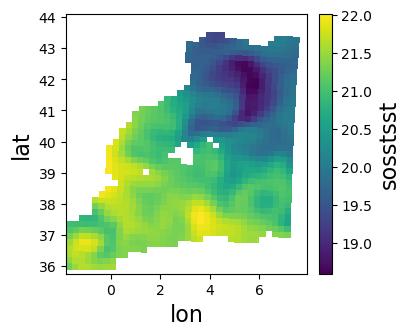

In [253]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.25))
data[5]['HR_Filtered'][3].isel(t=-1)['sosstsst'].plot(x='lon', y='lat', ax=ax)
ax.set(title=None, xlabel='lon', ylabel='lat')

[Text(0.5, 1.0, ''), Text(0.5, 0, 'lon'), Text(0, 0.5, 'lat')]

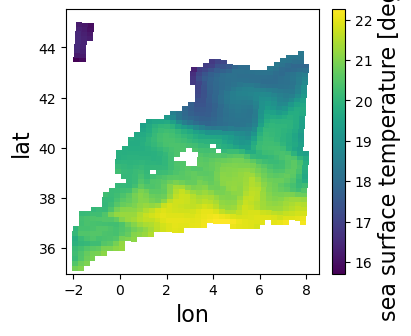

In [254]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.25))
data[5]['LR'].isel(t=-1)['sosstsst'].plot(x='lon', y='lat', ax=ax)
ax.set(title=None, xlabel='lon', ylabel='lat')

## Case of underfiltering

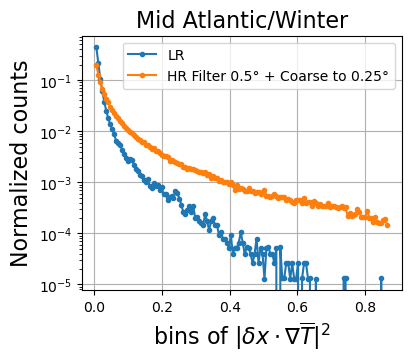

In [255]:
ifilter = 2
region = 3
quantity='diff_T_sqr'

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.5), sharey=True)
hists[region]['LR'][quantity].plot(ax=ax, ls='-', marker='.', label='LR')
hists[region]['HR_Filtered'][ifilter][quantity].plot(ax=ax, ls='-', marker='.', label='HR '+filters[ifilter]['label'])

ax.set(title=data[region]['label'], xlabel=r'bins of $|\delta x \cdot \nabla \overline{T}|^2$', ylabel='Normalized counts')
ax.set(yscale='log', xscale='linear')
ax.grid(True)
ax.legend(fontsize=10)
plt.show()

[Text(0.5, 1.0, ''), Text(0.5, 0, 'lon'), Text(0, 0.5, 'lat')]

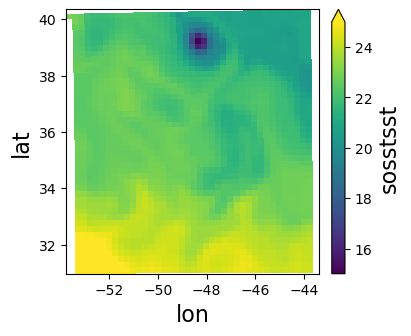

In [256]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.25))
data[3]['HR_Filtered'][2].isel(t=-1)['sosstsst'].plot(x='lon', y='lat', ax=ax, vmin=15, vmax=25)
ax.set(title=None, xlabel='lon', ylabel='lat')

[Text(0.5, 1.0, ''), Text(0.5, 0, 'lon'), Text(0, 0.5, 'lat')]

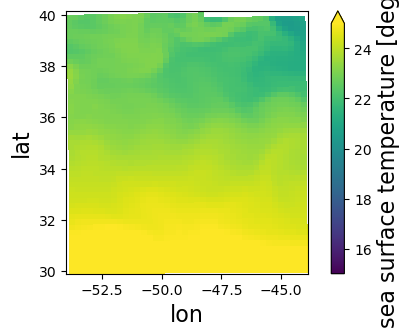

In [257]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.25))
data[3]['LR'].isel(t=-1)['sosstsst'].plot(x='lon', y='lat', ax=ax, vmin=15, vmax=25)
ax.set(title=None, xlabel='lon', ylabel='lat')

# L1-type

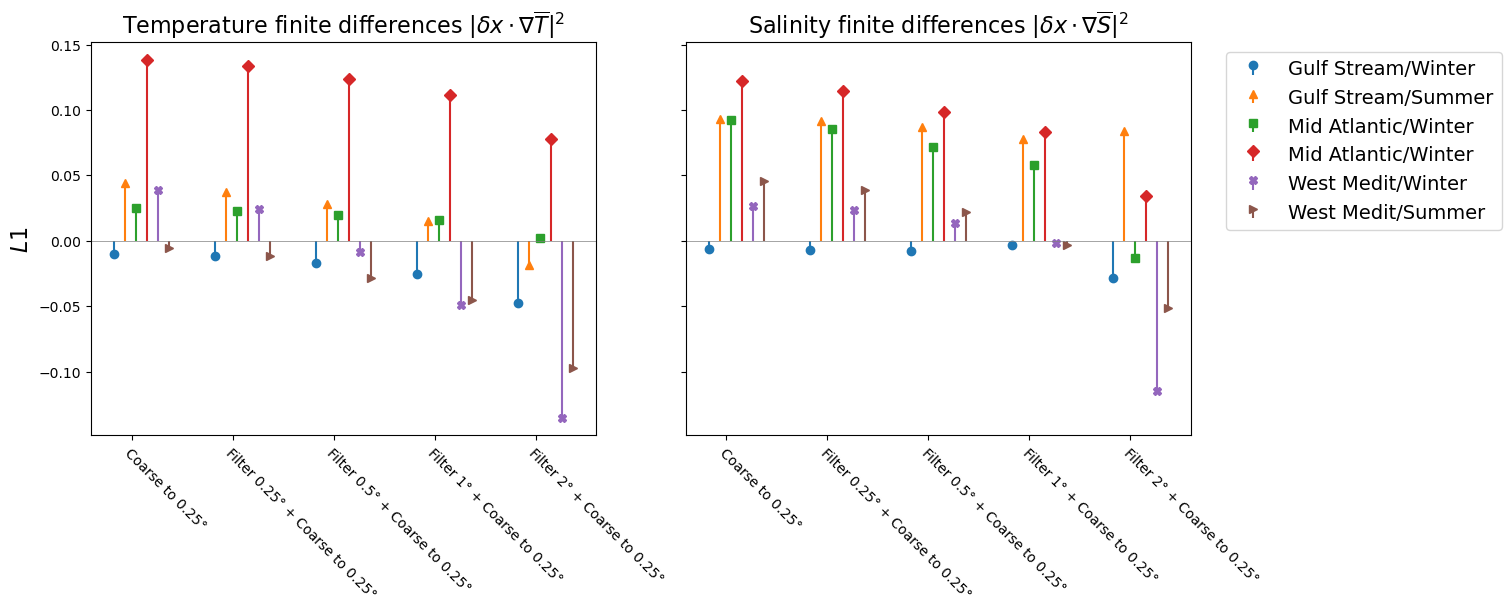

CPU times: user 7.11 s, sys: 386 ms, total: 7.5 s
Wall time: 53 s


In [213]:
%%time
fig, axis = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 6), sharey=True)
#fig.suptitle('Distance between 1D histograms $D_{KL}$ (eORCA025, Filtered eNATL60)')
x = np.arange(len(filters))
bar_width = 0.11
for i_dataset in range(len(data)) :
    marker_style = 'C'+str(i_dataset)+marker_list[i_dataset]
    line_style = 'C'+str(i_dataset)+'-'
    markerline, stemlines, baseline = axis[0].stem(x+(i_dataset)*bar_width, [L1(hists[i_dataset]['LR']['diff_T_sqr'], \
                                                                                hists[i_dataset]['HR_Filtered'][ifilter]['diff_T_sqr']) \
                                          for ifilter in range(len(filters))], markerfmt=marker_style, basefmt=" ", linefmt=line_style)
    markerline, stemlines, baseline = axis[1].stem(x+(i_dataset)*bar_width, [L1(hists[i_dataset]['LR']['diff_S_sqr'], \
                                                                                hists[i_dataset]['HR_Filtered'][ifilter]['diff_S_sqr']) \
                                          for ifilter in range(len(filters))], markerfmt=marker_style, basefmt=" ", \
                                                   linefmt=line_style, label=data[i_dataset]['label'])
for ax in axis :
    ax.set_xticks(x + 1.6*bar_width)
    ax.set_xticklabels([filt['label'] for filt in filters],fontsize=10,rotation = -45,ha="left", rotation_mode="anchor")
    ax.set(yscale='linear')
    ax.axhline(y=0., color='grey', ls='-', lw=0.5)
    #ax.set(ylim=[-0.2,0.2])
axis[0].set(title=r'Temperature finite differences $|\delta x \cdot \nabla \overline{T}|^2$', ylabel=r'$L1$')
axis[1].set(title=r'Salinity finite differences $|\delta x \cdot \nabla \overline{S}|^2$')
axis[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

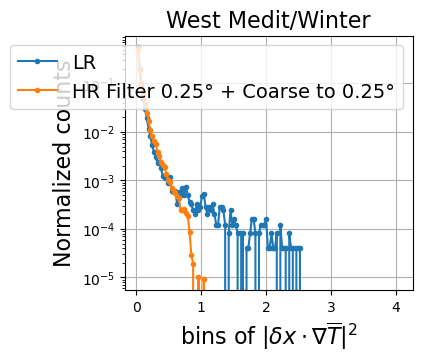

In [214]:
ifilter = 1 # pure coarse
region = 4
quantity='diff_T_sqr'

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.5), sharey=True)
hists[region]['LR'][quantity].plot(ax=ax, ls='-', marker='.', label='LR')
hists[region]['HR_Filtered'][ifilter][quantity].plot(ax=ax, ls='-', marker='.', label='HR '+filters[ifilter]['label'])

ax.set(title=data[region]['label'], xlabel=r'bins of $|\delta x \cdot \nabla \overline{T}|^2$', ylabel='Normalized counts')
ax.set(yscale='log')
ax.grid(True)
ax.legend()
plt.show()

# Time evolution of metrics

In [215]:
# initialize data structure for storing histograms
hists_vs_time=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists_vs_time[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists_vs_time[i]['HR'] = dict({'label' : 'eNATL60'})
    hists_vs_time[i]['LR'] = dict({'label' : 'eORCA025'})

In [216]:
%%time
normalized = False
for variable in ["diff_T_sqr", "diff_S_sqr"] :
    for i in range(len(data)) :
        #ref_hist = compute_1D_histogram(data[i]['HR_Filtered'][2][bord_cut], variable, nb_of_bins, bins=None).compute()
        ref_hist = compute_1D_histogram(data[i]['LR'], variable, nb_of_bins, bins=None).compute()
        ref_bins = ref_hist[variable+'_bin'].data
        
        hists_vs_time[i]['LR'][variable] = compute_1D_histogram_vs_time(data[i]['LR'][bord_cut], variable, nb_of_bins, bins=ref_bins).compute()
        hists_vs_time[i]['LR'][variable]['t'] = np.arange(len(hists_vs_time[i]['LR'][variable]['t']))
        for ifilter in range(len(filters)) :
            hists_vs_time[i]['HR_Filtered'][ifilter][variable] = compute_1D_histogram_vs_time(data[i]['HR_Filtered'][ifilter][bord_cut], \
                                                                                              variable, nb_of_bins, bins=ref_bins)
            hists_vs_time[i]['HR_Filtered'][ifilter][variable]['t'] = np.arange(len(hists_vs_time[i]['HR_Filtered'][ifilter][variable]['t']))

CPU times: user 4.05 s, sys: 52.3 ms, total: 4.1 s
Wall time: 7.86 s


In [217]:
region = 4
ifilter = 4
quantity='diff_T_sqr'

P = hists_vs_time[region]['LR'][quantity]
Q = hists_vs_time[region]['HR_Filtered'][ifilter][quantity]

P_full = hists[region]['LR'][quantity]
Q_full = hists[region]['HR_Filtered'][ifilter][quantity]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


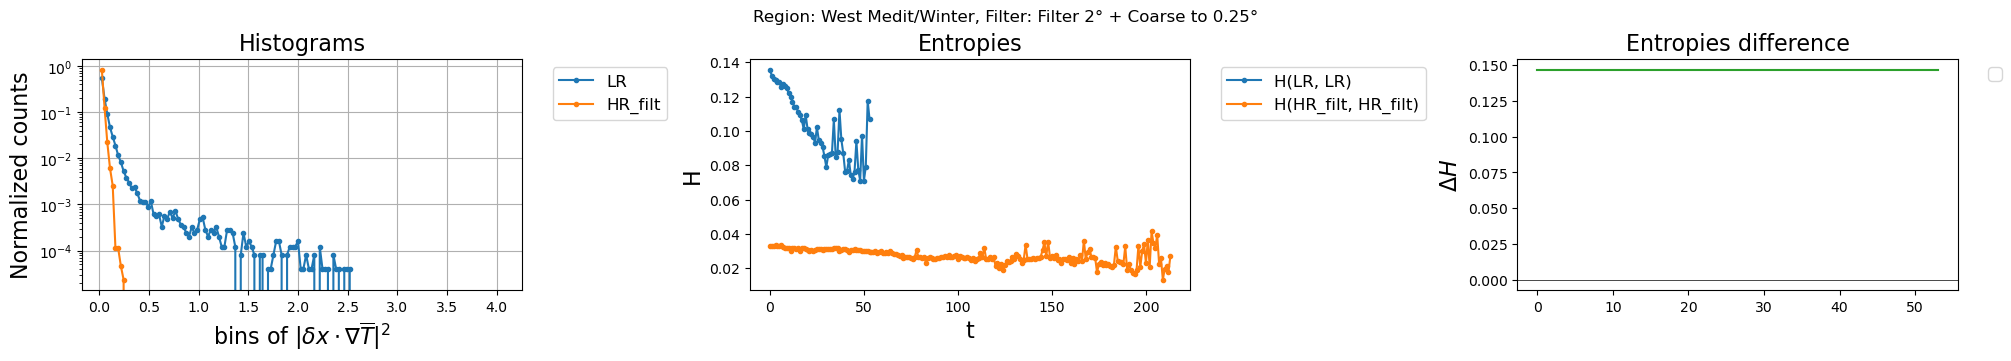

CPU times: user 1.22 s, sys: 293 ms, total: 1.51 s
Wall time: 1.5 s


In [220]:
%%time
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(20, 3.5))
fig.suptitle('Region: '+data[region]['label'] + ', Filter: '+filters[ifilter]['label'])

hists[region]['LR'][quantity].plot(ax=ax[0], ls='-', marker='.', label='LR')
hists[region]['HR_Filtered'][ifilter][quantity].plot(ax=ax[0], ls='-', marker='.', label='HR_filt')
ax[0].set(title='Histograms', xlabel=r'bins of $|\delta x \cdot \nabla \overline{T}|^2$', ylabel='Normalized counts')
ax[0].set(yscale='log'); ax[0].grid(True)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

H(P, P, dims=quantity+'_bin').plot(ax=ax[1], label='H(LR, LR)', marker='.')
H(Q, Q, dims=quantity+'_bin').plot(ax=ax[1], label='H(HR_filt, HR_filt)', marker='.')
#H(P, Q, dims=quantity+'_bin').plot(ax=ax[1], label='H(LR, HR_filt)', marker='.')

# (H(P, Q, dims=quantity+'_bin')-H(P, P, dims=quantity+'_bin')).plot(ax=ax[2], label='H(LR, HR_filt) - H(LR, LR)', \
#                                                                    marker='.', color=line_colors[2])
# # (H(Q, Q, dims=quantity+'_bin')-H(P, P, dims=quantity+'_bin')).plot(ax=ax[2], label='H(HR_filt, HR_filt) - H(LR, LR)', \
# #                                                                    marker='.', color=line_colors[3])
# (H(P, Q, dims=quantity+'_bin')-H(Q, P, dims=quantity+'_bin')).plot(ax=ax[2], label='H(LR, HR_filt) - H(HR_filt, LR)', \
#                                                                    marker='.', color=line_colors[4])
ax[2].plot(np.full(len(P['t']), (H(P_full, Q_full)-H(P_full, P_full)).values), color=line_colors[2])
#ax[2].plot(np.full(len(P['time_counter']), (H(Q_full, Q_full)-H(P_full, P_full)).values), color=line_colors[3])
#ax[2].plot(np.full(len(P['time_counter']), (H(P_full, Q_full)-H(Q_full, P_full)).values), color=line_colors[4])
ax[2].axhline(0., color='k', lw=0.5)
ax[1].set(title='Entropies', ylabel='H')
ax[2].set(title='Entropies difference', ylabel=r'$\Delta H$' )
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.show()

# Spectra

In [222]:
# without interpolation
def prepare_data_for_spec(data, variable) :
    res = data[variable].dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    
    if ("e1t" in data) :
        delta_x = res['e1t'].mean(skipna=True).values
        delta_y = res['e2t'].mean(skipna=True).values
    else :
        delta_x = gsw.distance(data.lon,data.lat).mean(skipna=True)
        delta_y = gsw.distance(data.lon,data.lat).mean(skipna=True)
        
    res.coords['x'] = res.coords['x']*delta_x
    res.coords['y'] = res.coords['y']*delta_y 

    # fill in nans
    # avg = step0.mean().compute()
    # data_filled_nans = interpolated_field.fillna(avg)
    res = res.interpolate_na(dim="x", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="y", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")

    res = res.drop(['depth', 'e1f', 'e1u', 'e1v', 'e2f', 'e2u', 'e2v', \
                    'lat', 'lon', 'nav_lat', 'nav_lon', 'e1t', 'e2t'], errors='ignore')
    return res

In [223]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor=4) :
    #prepared_data = uniform_grid_interpolation(data.drop(['tmask']), variable) # with interpolation on a uniform grid
    prepared_data = prepare_data_for_spec(data.drop(['tmask', 'area', 'mask'], errors='ignore'), variable) # without interpolation 
    isotropic_power_spec = xrft.isotropic_power_spectrum(prepared_data, dim=['x','y'], detrend='linear', nfactor=2, truncate=True)
    return isotropic_power_spec.rename('Spatial_spectrum')

In [224]:
# initialize data structure for storing spectra
spec=[dict() for i in range(len(data))]
for i in range(len(data)) :
    spec[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    spec[i]['HR'] = dict({'label' : 'eNATL60'})
    spec[i]['LR'] = dict({'label' : 'eORCA025'})

In [225]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [235]:
%%time 
for quantity in ['sosstsst', 'sosaline'] :
    for i in range(len(data)) :
        for key_dict in ['LR', 'HR'] :
            spec[i][key_dict][quantity] = (wrapper_xrtf_isotropic_PS(data[i][key_dict], quantity)).mean(dim='t').compute()
        for ifilter in range(len(filters)) :
            spec[i]['HR_Filtered'][ifilter][quantity] = (wrapper_xrtf_isotropic_PS(data[i]['HR_Filtered'][ifilter], quantity)).\
            mean(dim='t').compute()

CPU times: user 1min 26s, sys: 2.1 s, total: 1min 28s
Wall time: 20min 56s


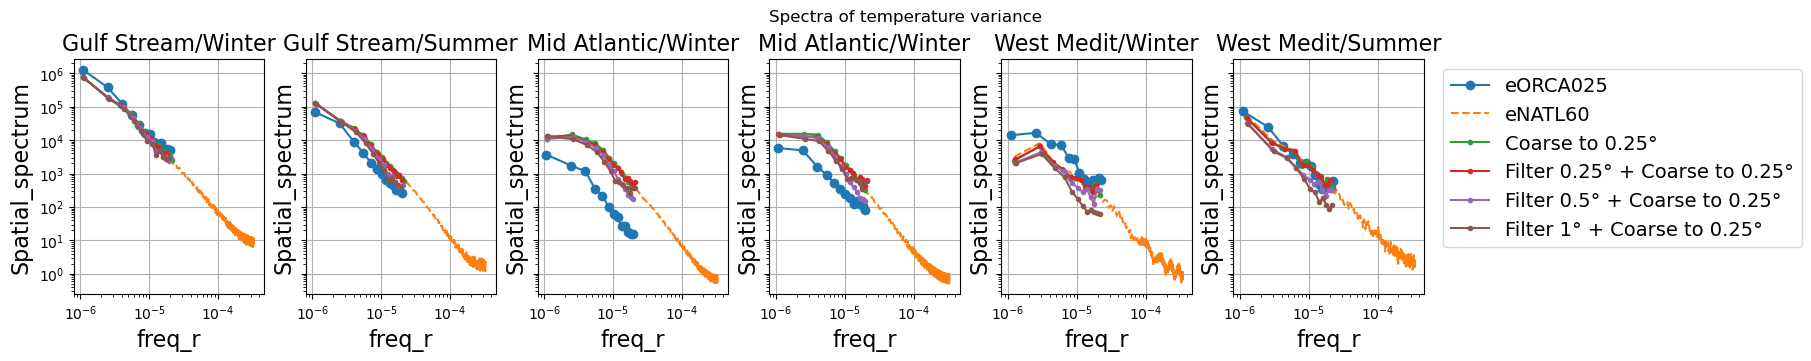

In [236]:
fig, ax = plt.subplots(ncols=6, constrained_layout=True, figsize=(18,3.5), sharex=True, sharey=True)
fig.suptitle('Spectra of temperature variance')
for data_i in range(len(data)) :
    spec[data_i]['LR']['sosstsst'].plot(x='freq_r', ax=ax[data_i], marker='o', label='eORCA025')
    spec[data_i]['HR']['sosstsst'].plot(x='freq_r', ax=ax[data_i], ls='--', label='eNATL60')
    #for ifilter in range(len(filters)) :
    for ifilter in range(4) :
        spec[data_i]['HR_Filtered'][ifilter]['sosstsst'].plot(x='freq_r', marker='.', ax=ax[data_i], label=filters[ifilter]['label'])
    ax[data_i].set(title=data[data_i]['label'], xscale='log', yscale='log'); ax[data_i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

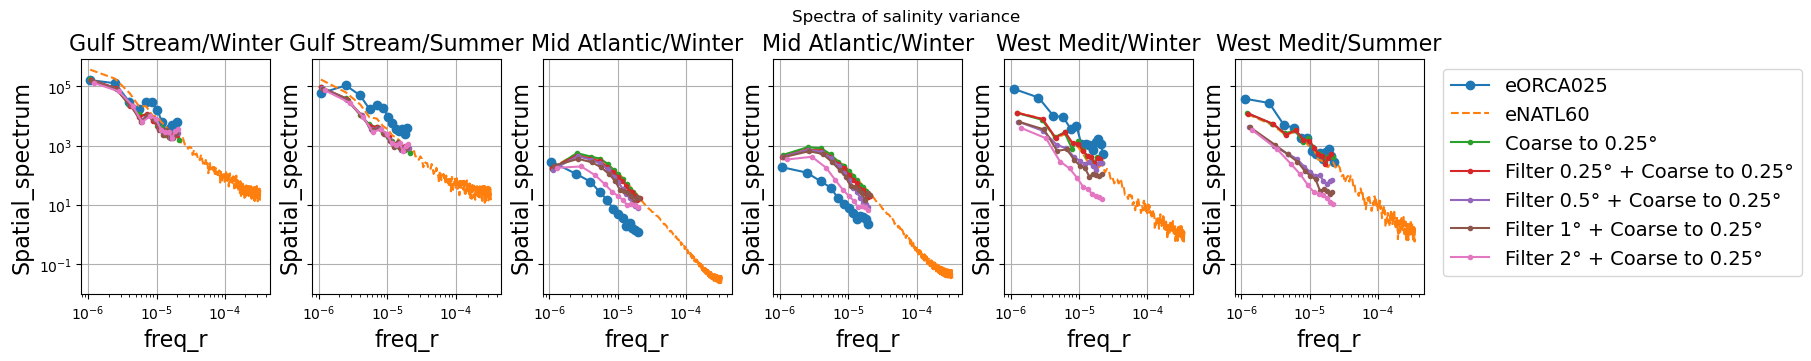

In [237]:
fig, ax = plt.subplots(ncols=6, constrained_layout=True, figsize=(18,3.5), sharex=True, sharey=True)
fig.suptitle('Spectra of salinity variance')
for data_i in range(len(data)) :
    spec[data_i]['LR']['sosaline'].plot(x='freq_r', ax=ax[data_i], marker='o', label='eORCA025')
    spec[data_i]['HR']['sosaline'].plot(x='freq_r', ax=ax[data_i], ls='--', label='eNATL60')
    for ifilter in range(len(filters)) :
        spec[data_i]['HR_Filtered'][ifilter]['sosaline'].plot(x='freq_r', marker='.', ax=ax[data_i], label=filters[ifilter]['label'])
    ax[data_i].set(title=data[data_i]['label'], xscale='log', yscale='log'); ax[data_i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()